In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Loading the dataset 
df = pd.read_csv('Mall_Customers.csv')

# Select relevant features for clustering
features = ['Age', 'Annual Income', 'Spending Score']
X = df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [49]:
df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,150000,39
1,2,Male,21,150000,81
2,3,Female,20,160000,6
3,4,Female,23,160000,77
4,5,Female,31,170000,40


In [52]:
#Data Preparation
#Making a copy of our dataset.
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual Income   200 non-null    int64 
 4   Spending Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [55]:
#Removing missing values for the new dataset(copy of dataset).
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual Income   200 non-null    int64 
 4   Spending Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [58]:
df2.drop(['Gender'], axis=1, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   CustomerID      200 non-null    int64
 1   Age             200 non-null    int64
 2   Annual Income   200 non-null    int64
 3   Spending Score  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


Customer Segments:
               Age  Annual Income  Spending Score  Count
Cluster                                                 
0        56.333333  542666.666667       49.066667     45
1        26.600000  560500.000000       47.900000     40
2        32.692308  865384.615385       82.128205     39
3        41.939394  889393.939394       16.969697     33
4        45.523810  262857.142857       19.380952     21
5        25.272727  257272.727273       79.363636     22


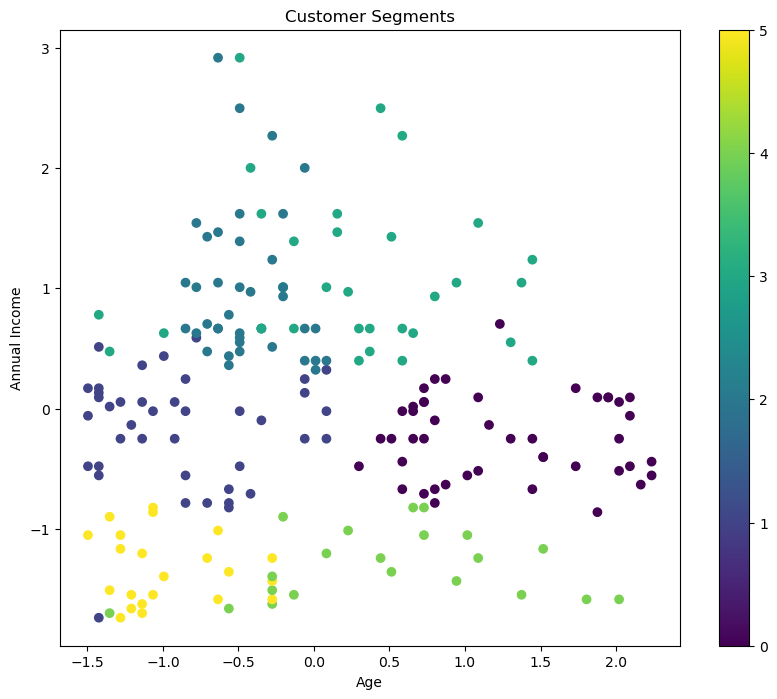


Actionable Insights:
- Cluster 0: Affluent older customers. Focus on premium, high-quality products and services.
- Cluster 1: High income, low spending. Personalized luxury item promotions may increase spending.
- Cluster 3: Low spenders. Offer promotions and loyalty programs to increase engagement.
- Cluster 4: Low spenders. Offer promotions and loyalty programs to increase engagement.
- Cluster 5: Young high spenders. Target with trendy products and social media campaigns.


In [77]:
import os
import warnings

# Suppress the KMeans memory leak warning
os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", message="MiniBatchKMeans is known to have a memory leak on Windows with MKL")
from sklearn.cluster import MiniBatchKMeans

# Function to determine optimal number of clusters using silhouette score
def optimal_number_of_clusters(df2, max_k):
    silhouette_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(df2)
        score = silhouette_score(df2, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores.index(max(silhouette_scores)) + 2

# Finding the optimal number of clusters
max_k = 10
optimal_k = optimal_number_of_clusters(X_scaled, max_k)

# Applying K-means clustering with the optimal number of clusters
kmeans = MiniBatchKMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding cluster labels to the original dataframe
df2['Cluster'] = clusters

# Analyzing the segments
segment_analysis = df2.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income': 'mean',
    'Spending Score': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

print("Customer Segments:")
print(segment_analysis)

# Visualizing the clusters (using the first two features for simplicity)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Customer Segments')
plt.colorbar(scatter)
plt.show()

# Function to get actionable insights
def get_insights(segment_analysis):
    insights = []
    for cluster, row in segment_analysis.iterrows():
        if row['Age'] < 30 and row['Spending Score'] > 70:
            insights.append(f"Cluster {cluster}: Young high spenders. Target with trendy products and social media campaigns.")
        elif row['Age'] > 50 and row['Annual Income'] > 80:
            insights.append(f"Cluster {cluster}: Affluent older customers. Focus on premium, high-quality products and services.")
        elif row['Spending Score'] < 30:
            insights.append(f"Cluster {cluster}: Low spenders. Offer promotions and loyalty programs to increase engagement.")
        elif row['Annual Income'] > 90 and row['Spending Score'] < 50:
            insights.append(f"Cluster {cluster}: High income, low spending. Personalized luxury item promotions may increase spending.")
    return insights

# Getting and printing actionable insights
actionable_insights = get_insights(segment_analysis)
print("\nActionable Insights:")
for insight in actionable_insights:
    print("- " + insight)